# Principal Component Analysis (PCA) of Stock Returns

This notebook demonstrates how PCA can be used to analyze stock returns and extract meaningful factors that explain the variation in the data. We'll explore:
1. The correlation structure of stock returns
2. Why high correlations can be problematic for models
3. How PCA helps diagonalize the covariance matrix
4. Interpretation of principal components
5. The non-stationary nature of these factors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

## 1. Loading and Preparing the Data

In [4]:
# Load all sheets from the Excel file
excel_file = pd.ExcelFile('stock_returns_2021_2022.xlsx')
sheet_names = excel_file.sheet_names

# Initialize empty list to store dataframes
dfs = []

# Read each sheet and add to list
for sheet in sheet_names:
    df_sheet = pd.read_excel(excel_file, sheet_name=sheet)
    df_sheet['Stock'] = sheet  # Add column to identify stock
    dfs.append(df_sheet)

# Concatenate all dataframes
df = pd.concat(dfs, ignore_index=True)

# Group by date and pivot to get stocks as columns
df = df.pivot_table(
    index='Date',
    columns='Stock', 
    values='Close',
    aggfunc='first'
).reset_index()

# Sort by date in ascending order to ensure proper return calculation
df = df.sort_values('Date')

# Calculate log returns for each stock column (excluding Date)
stock_columns = df.columns.difference(['Date'])
# Using shift(1) since data is in ascending order - newer minus older prices
df[stock_columns] = np.log(df[stock_columns] / df[stock_columns].shift(1))

# Drop first row since it will have NaN values after calculating returns
df = df.dropna()

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
display(df.head())

# Check for missing values
print("\nMissing values:")
display(df.isnull().sum())

Dataset Shape: (253, 6)

First few rows:


Stock,Date,AAPL_2021_2022,AMZN_2021_2022,GM_2021_2022,MSFT_2021_2022,SPX 2021_2022
1,2021-01-05,0.012288,0.009992,0.027993,0.000964,0.007058
2,2021-01-06,-0.034241,-0.025233,0.031193,-0.026271,0.005694
3,2021-01-07,0.033554,0.007555,0.007880,0.028060,0.014738
4,2021-01-08,0.008594,0.006430,-0.006020,0.006074,0.005477
5,2021-01-11,-0.023523,-0.021726,0.044290,-0.009746,-0.006576



Missing values:


Stock
Date              0
AAPL_2021_2022    0
AMZN_2021_2022    0
GM_2021_2022      0
MSFT_2021_2022    0
SPX 2021_2022     0
dtype: int64

## 2. Correlation Analysis

Let's examine the correlation structure of our stock returns. High correlations between assets can lead to multicollinearity issues in models.

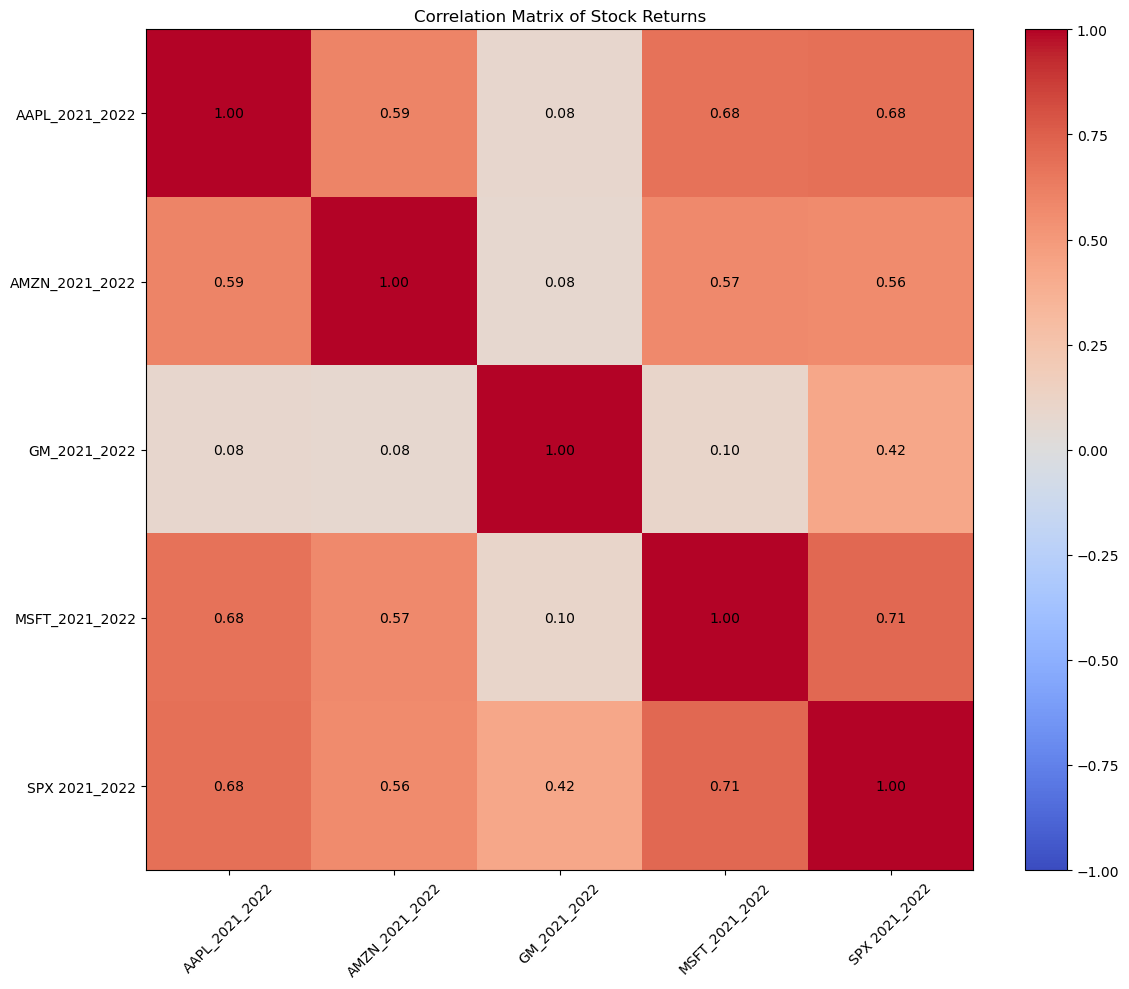

Average correlation between stocks: 0.448


In [6]:
# Calculate correlation matrix excluding the Date column
correlation_matrix = df.drop('Date', axis=1).corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im)

# Add correlation values as text annotations
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        text = plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                       ha='center', va='center')

# Set ticks and labels
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)

plt.title('Correlation Matrix of Stock Returns')
plt.tight_layout()
plt.show()

# Calculate average correlation
avg_correlation = (correlation_matrix.sum().sum() - len(correlation_matrix)) / (len(correlation_matrix) * (len(correlation_matrix) - 1))
print(f"Average correlation between stocks: {avg_correlation:.3f}")

## 3. Why High Correlations are Problematic

High correlations between features can cause several issues in modeling:

1. **Multicollinearity in Linear Regression** - When features are highly correlated, it becomes difficult to determine their individual effects on the target variable. The regression coefficients become unstable and sensitive to small changes in the data.

2. **Unstable weights in Neural Networks**

3. **Redundant information** - When features are highly correlated, they essentially contain the same information. This redundancy:
   - Makes the model more complex than necessary
   - Increases computational cost without adding predictive value 
   - Can lead to overfitting as the model may give too much importance to redundant features
   - Makes interpretation difficult since the effects of correlated features cannot be separated

## 4. Principal Component Analysis

Now let's apply PCA to transform our correlated returns into uncorrelated principal components. The key goal is to diagonalize the covariance matrix, meaning we want to find a transformation that makes all off-diagonal elements zero.

### Two Mathematical Formulations of PCA

PCA can be understood through two equivalent approaches, each providing a different perspective on how we achieve diagonalization.

#### 1. Singular Value Decomposition (SVD) Approach

Let $X$ be our $n \times p$ data matrix where:
- $n$ is the number of observations (trading days)
- $p$ is the number of features (stocks)

SVD decomposes $X$ into:

$X = U\Sigma V^T$

where:
- $U$ is an $n \times n$ orthogonal matrix containing left singular vectors
- $\Sigma$ is an $n \times p$ diagonal matrix with singular values
- $V^T$ is a $p \times p$ orthogonal matrix containing right singular vectors

The principal components are given by $XV = U\Sigma$

To see how this diagonalizes the covariance matrix:
1. Start with the covariance of principal components: $Cov(XV)$
2. Expand using definition: $\frac{1}{n-1}(XV)^T(XV)$
3. Substitute $X = U\Sigma V^T$: $\frac{1}{n-1}(V^T V\Sigma^T U^T)(U\Sigma V^T V)$
4. Since $V$ is orthogonal, $V^T V = I$: $\frac{1}{n-1}(\Sigma^T U^T)(U\Sigma)$
5. Since $U$ is orthogonal, $U^T U = I$: $\frac{1}{n-1}\Sigma^T\Sigma$
6. This is diagonal since $\Sigma$ is diagonal!

#### 2. Eigendecomposition of Covariance Matrix

The covariance matrix approach:

1. Start with covariance matrix:
   $S = \frac{1}{n-1}X^TX$

2. Find eigendecomposition:
   $S = V\Lambda V^T$

   where:
   - $S$ is the $p \times p$ covariance matrix
   - $V$ contains the eigenvectors
   - $\Lambda$ is a diagonal matrix of eigenvalues

3. Transform data using $V$:
   $Cov(XV) = V^TSV = V^T(V\Lambda V^T)V = \Lambda$
   
   Let's break this down:
   - First multiply $V^T V = I$ on the left: $(V^T V)\Lambda V^T V = \Lambda$
   - This simplifies to $I\Lambda I = \Lambda$
   - Since $\Lambda$ is diagonal, the transformed covariance is diagonal!

### Connecting the Two Approaches

Here's how these formulations are equivalent:

1. Begin with SVD decomposition:
   $X = U\Sigma V^T$

2. Calculate covariance matrix:
   $S = \frac{1}{n-1}X^TX = \frac{1}{n-1}(V\Sigma^T U^T)(U\Sigma V^T)$

3. Simplify using $U^TU = I$:
   $S = \frac{1}{n-1}V\Sigma^T\Sigma V^T$

4. Note $\Sigma^T\Sigma$ is diagonal with entries $\sigma_i^2$, so:
   $\frac{1}{n-1}\Sigma^T\Sigma = \Lambda$ where $\lambda_i = \frac{\sigma_i^2}{n-1}$

5. Therefore:
   $S = V\Lambda V^T$
   
   This shows that:
   - The eigenvalues $\lambda_i$ are scaled versions of squared singular values $\sigma_i^2$
   - The eigenvectors in $V$ are the same as the right singular vectors
   - Both methods produce the same diagonalization, just viewed through different lenses


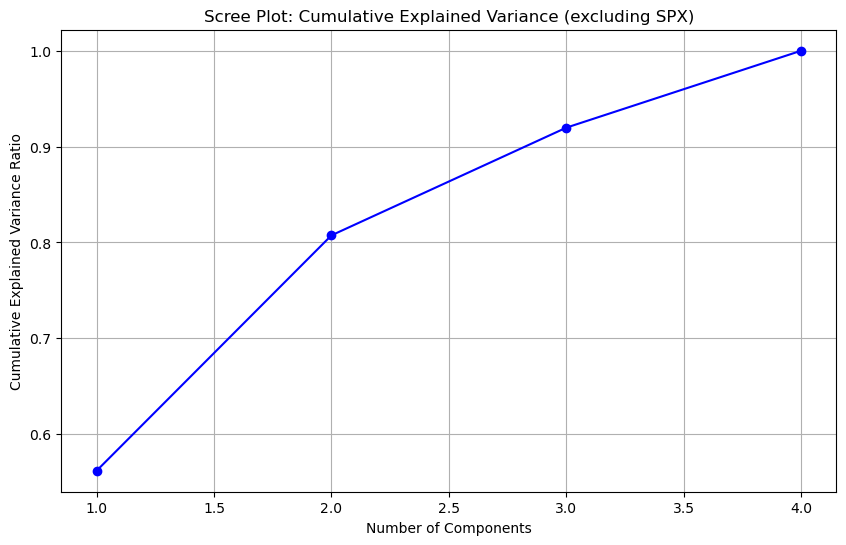

Explained variance ratio for first 3 components (excluding SPX):
PC1: 0.562
PC2: 0.246
PC3: 0.112


In [8]:
# Remove SPX from the data and drop the Date column
df_no_spx = df.drop(['SPX 2021_2022', 'Date'], axis=1)

# Standardize the data
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(df_no_spx)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(returns_scaled)

# Create DataFrame with principal components
pca_df = pd.DataFrame(
    pca_result,
    columns=[f'PC{i+1}' for i in range(len(df_no_spx.columns))]
)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot: Cumulative Explained Variance (excluding SPX)')
plt.grid(True)
plt.show()

# Print explained variance for first 3 components
print("Explained variance ratio for first 3 components (excluding SPX):")
for i, ratio in enumerate(pca.explained_variance_ratio_[:3]):
    print(f"PC{i+1}: {ratio:.3f}")

## 5. Interpretation of Principal Components

Let's examine the loadings (eigenvectors) of the first three principal components to understand what they represent.

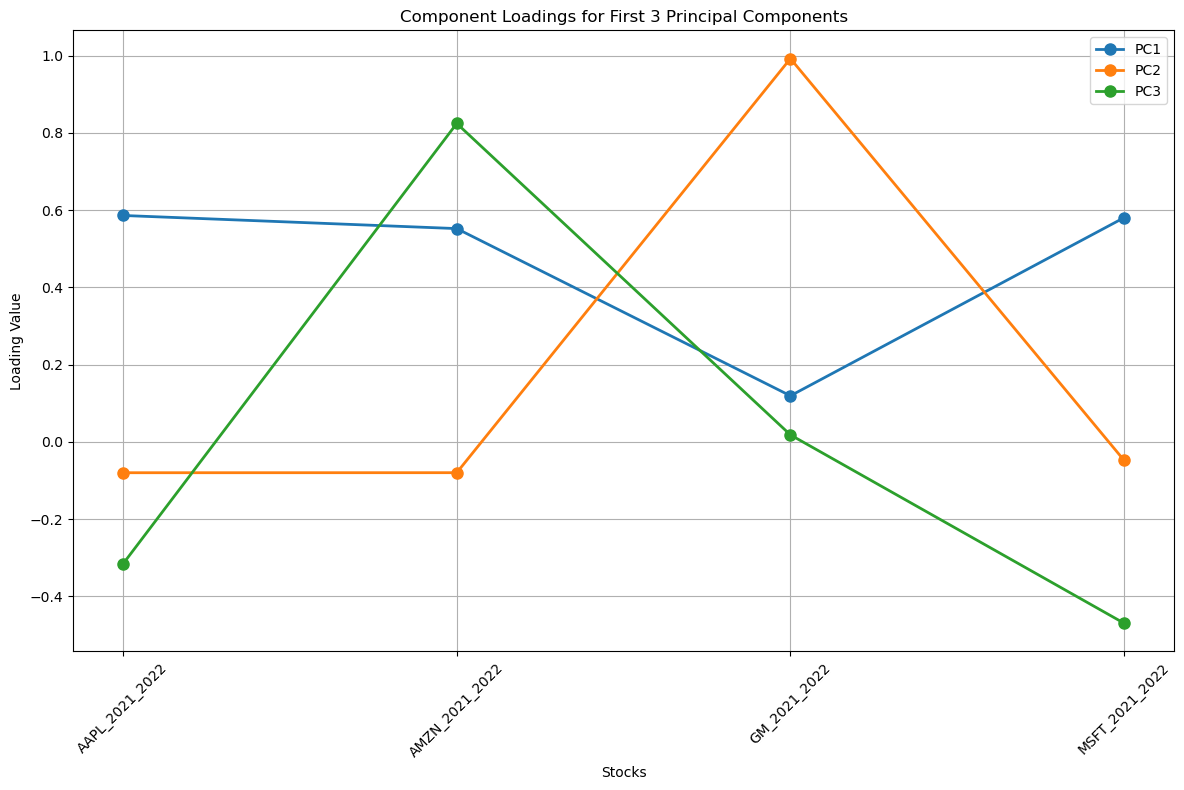

Top contributors to each principal component:

PC1:
AAPL_2021_2022: 0.586
MSFT_2021_2022: 0.581
AMZN_2021_2022: 0.552

PC2:
GM_2021_2022: 0.992
AAPL_2021_2022: 0.080
AMZN_2021_2022: 0.080

PC3:
AMZN_2021_2022: 0.824
MSFT_2021_2022: 0.469
AAPL_2021_2022: 0.316


In [9]:
# Get component loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(df_no_spx.columns))],
    index=df_no_spx.columns
)

# Plot loadings for first 3 PCs on a single plot
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.plot(loadings.index, loadings[f'PC{i+1}'], 
             marker='o', 
             linewidth=2, 
             markersize=8,
             label=f'PC{i+1}')

plt.title('Component Loadings for First 3 Principal Components')
plt.xlabel('Stocks')
plt.ylabel('Loading Value')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print top contributors for each PC
print("Top contributors to each principal component:")
for i in range(3):
    print(f"\nPC{i+1}:")
    top_contributors = loadings[f'PC{i+1}'].abs().sort_values(ascending=False).head(3)
    for stock, loading in top_contributors.items():
        print(f"{stock}: {loading:.3f}")

## 6. Non-stationarity of Principal Components

Let's examine how the principal components evolve over time to demonstrate their non-stationary nature.

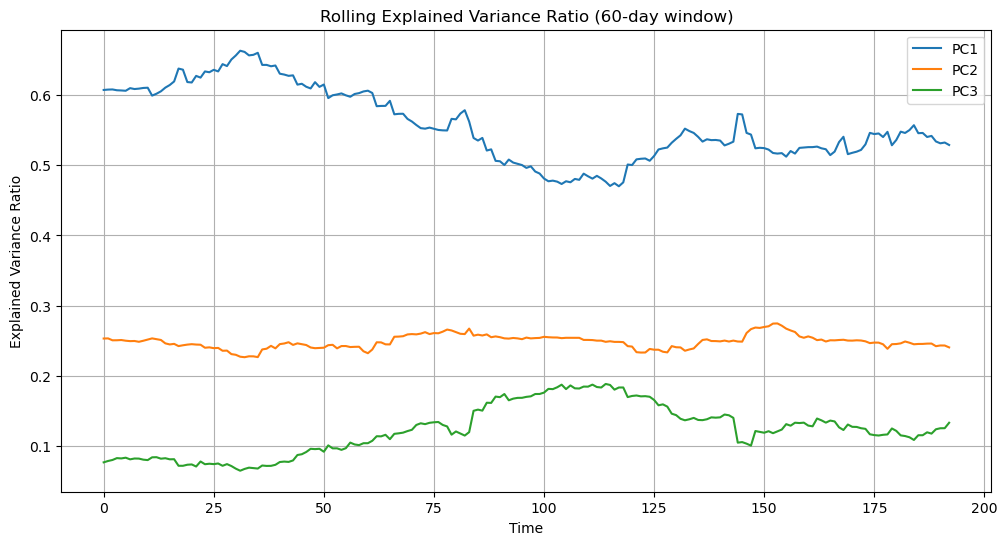

In [26]:
# Calculate rolling PCA (using 60-day windows)
window_size = 60
rolling_pca = []

for i in range(window_size, len(df_no_spx)):
    window_data = df_no_spx.iloc[i-window_size:i]
    window_scaled = StandardScaler().fit_transform(window_data)
    pca_window = PCA()
    pca_window.fit(window_scaled)
    rolling_pca.append(pca_window.explained_variance_ratio_[:3])

rolling_pca_df = pd.DataFrame(rolling_pca, columns=['PC1', 'PC2', 'PC3'])

# Plot rolling explained variance
plt.figure(figsize=(12, 6))
for col in rolling_pca_df.columns:
    plt.plot(rolling_pca_df.index, rolling_pca_df[col], label=col)
plt.xlabel('Time')
plt.ylabel('Explained Variance Ratio')
plt.title('Rolling Explained Variance Ratio (60-day window)')
plt.legend()
plt.grid(True)
plt.show()

## 7. Practical Applications and Conclusions

The PCA analysis reveals several important insights:

1. **Market Factor**: The first principal component typically represents a market-wide factor, capturing systematic risk.
2. **Sector Factors**: The second and third components often capture sector-specific movements.
3. **Idiosyncratic Risk**: The remaining components represent stock-specific factors.

These findings have important implications for modeling:

1. **Dimensionality Reduction**: We can reduce the number of features while preserving most of the variance.
2. **Risk Decomposition**: We can separate systematic and idiosyncratic risk.
3. **Model Stability**: Using principal components instead of raw returns can improve model stability.

However, it's crucial to note that:

1. The principal components are not stationary over time.
2. The interpretation of components may change with market conditions.
3. Regular rebalancing of the PCA model may be necessary.